In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# np.random.seed(0)

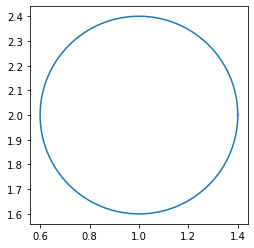

In [2]:
theta = np.linspace( 0 , 2 * np.pi , 1000)
 
radius = 0.4
 
x_ortoform = radius * np.cos( theta ) + 1
y_ortoform = radius * np.sin( theta ) + 2

fig1, ax1 = plt.subplots()
ax1.set_aspect('equal')
ax1.plot(x_ortoform, y_ortoform)

In [3]:
H = np.random.rand(3, 3)
H[-1,-1] = 1.
ortoform = np.stack((x_ortoform, y_ortoform, np.ones(x_ortoform.shape[0])))
oval = H @ ortoform 
oval = oval / oval[2]

In [4]:
c = H @ np.array([[1], [2], [1]])
c = c / c[-1][0]

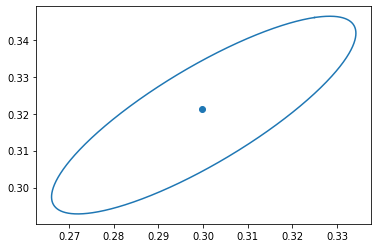

In [5]:
plt.plot(oval[0], oval[1])
plt.scatter(c[0], c[1])

In [6]:
c

array([[0.29979581],
       [0.32133536],
       [1.        ]])

In [7]:
oval

array([[0.32496768, 0.32483096, 0.3246935 , ..., 0.32523883, 0.32510363,
        0.32496768],
       [0.34604489, 0.34601954, 0.34599331, ..., 0.34609294, 0.34606936,
        0.34604489],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ]])

In [8]:
def gradient(x, y):
#     x_diff = np.zeros_like(x)
#     x_diff[1: -1] = x[2:] - x[:-2]
#     x_diff[0] = x[1] - x[-1]
#     x_diff[-1] = x[0] - x[-2]

#     y_diff = np.zeros_like(y)
#     y_diff[1: -1] = y[2:] - y[:-2]
#     y_diff[0] = y[1] - y[-1]
#     y_diff[-1] = y[0] - y[-2]

    x_diff = np.zeros_like(x)
    x_diff[2: -2] = x[4:] - x[:-4]
    x_diff[:2] = x[2:4] - x[-2:]
    x_diff[-1] = x[1] - x[-3]
    x_diff[-2] = x[0] - x[-4]
    
    y_diff2 = np.zeros_like(x)
    y_diff2[2: -2] = y[:-4] - y[4:]
    y_diff2[0] = y[-2] - y[2]
    y_diff2[1] = y[-1] - y[3]
    y_diff2[-1] = y[-3] - y[1]
    y_diff2[-2] = y[-4] - y[0]
    
    y_diff1 = np.zeros_like(x)
    y_diff1[1: -1] = y[2:] - y[:-2]
    y_diff1[0] = y[1] - y[-1]
    y_diff1[-1] = y[0] - y[-1]
    
    y_diff = y_diff2 + 8 * y_diff1

    return y_diff / (3 *x_diff)

In [9]:
def tang_intersec(p1, p2, gr1, gr2):
    point_x = (gr1 * p1[0] - gr2 * p2[0] + p2[1] - p1[1]) / (gr1 - gr2)
    point_y = gr2 * (point_x - p2[0]) + p2[1]
    return np.array([point_x, point_y])

In [10]:
def line_intersec(p1, p2, p3, p4):
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    x4, y4 = p4
    point_x = ((x2 - x1) * (y3 * x4 - y4 * x3) - (x4 - x3) * (y1 * x2 - y2 * x1)) / ((y3 - y4) * (x2 - x1) - (y1 - y2) * (x4 - x3))
    point_y = y1 + ((point_x - x1) * (y2 - y1)) / (x2 - x1)
    return np.array([point_x, point_y])

In [11]:
def wurf(p1, p2, p3, p4):
    a = np.linalg.norm(p2 - p1)
    b = np.linalg.norm(p3 - p2)
    c = np.linalg.norm(p4 - p3)
    return a * c / b / (a + b + c)

In [12]:
def calc_F(A, T, L, R, P, C, B, D, E, F, vis=False):
    M = line_intersec(A, L, C, F)
    G = line_intersec(A, L, P, R)
    O = line_intersec(A, L, T, R)
    K = line_intersec(T, R, C, F)
    U = line_intersec(P, O, C, F)        
    v1 = wurf(C, D, A, B)
    v2 = wurf(C, E, L, P)
    v3 = wurf(L, O, A, G)
    v4 = wurf(L, A, M, G)
    v5 = wurf(E, T, D, F)
    v6 = wurf(P, R, B, F)
    w1 = wurf(M, A, O, L)
    w2 = wurf(K, T, O, R)
    w3 = wurf(U, D, O, P)
    return np.abs(w1 - 1) + np.abs(w2 - 1) + np.abs(w3 - 1) + np.abs(v1 - v3) + np.abs(v1 * v2 - 1) + np.abs(v4 - v1 + 1)

In [13]:
def find_center(oval):
    x = oval[0]
    y = oval[1]
    n = x.shape[0]
    
    grad = gradient(x, y)
    
    L_idx, R_idx = np.random.randint(low=0, high=n, size=2)
    if (L_idx < R_idx):
        L_idx, R_idx = R_idx, L_idx
        
    L = np.array([x[L_idx], y[L_idx]])
    R = np.array([x[R_idx], y[R_idx]])
    P = tang_intersec(L, R, grad[L_idx], grad[R_idx])
    
    func_best = np.inf
    A_best_idx = 0
    T_best_idx = 0
    
    for A_idx in range(R_idx + 1, L_idx - 1):
        A = np.array([x[A_idx], y[A_idx]])
        C = tang_intersec(A, L, grad[A_idx], grad[L_idx])
        B = tang_intersec(A, R, grad[A_idx], grad[R_idx])      
        for T_idx in range(A_idx + 1, L_idx):
            T = np.array([x[T_idx], y[T_idx]])            
            E = tang_intersec(T, L, grad[T_idx], grad[L_idx])
            F = tang_intersec(T, R, grad[T_idx], grad[R_idx])
            D = tang_intersec(A, T, grad[A_idx], grad[T_idx])            
            func = calc_F(A, T, L, R, P, C, B, D, E, F)
            if func < func_best:
                func_best = func
                A_best_idx = A_idx
                T_best_idx = T_idx
    
    
    for T_idx in range(L_idx + 1, n + R_idx - 1):
        E = tang_intersec(T, L, grad[T_idx%n], grad[L_idx])
        F = tang_intersec(T, R, grad[T_idx%n], grad[R_idx])
        for A_idx in range(T_idx + 1, n + R_idx - 1):
            A_idx = A_idx % n
            T_idx = T_idx % n
            A = np.array([x[A_idx], y[A_idx]])
            T = np.array([x[T_idx], y[T_idx]])
            
            C = tang_intersec(A, L, grad[A_idx], grad[L_idx])
            B = tang_intersec(A, R, grad[A_idx], grad[R_idx]) 
            D = tang_intersec(A, T, grad[A_idx], grad[T_idx])    
 
            func = calc_F(A, T, L, R, P, C, B, D, E, F)
            if func < func_best:
                func_best = func
                A_best_idx = A_idx
                T_best_idx = T_idx
                
    return func_best, A_best_idx, T_best_idx, L_idx, R_idx

In [14]:
start = time.time()
func_best, A_idx, T_idx, L_idx, R_idx = find_center(oval)         
print(time.time() - start)

57.60516929626465


In [15]:
A_idx, T_idx, L_idx, R_idx

(82, 960, 783, 343)

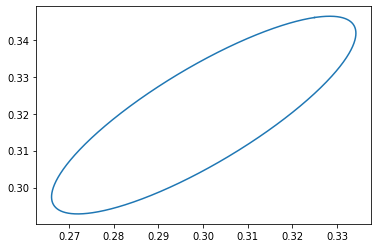

In [16]:
plt.plot(oval[0], oval[1])

In [17]:
x = oval[0]

In [18]:
x_limit = sorted(np.unique(x))
y_limit = sorted(np.unique(y))

NameError: name 'y' is not defined

In [ ]:
x_min_idx, x_max_idx = np.argmin(x), np.argmax(x)

In [ ]:
x_max_idx

In [ ]:
func_best

In [ ]:
x = oval[0]
y = oval[1]
n = x.shape[0]

grad = gradient(x, y)

L_idx, R_idx = np.random.randint(low=0, high=n, size=2)
if (L_idx < R_idx):
    L_idx, R_idx = R_idx, L_idx

L = np.array([x[L_idx], y[L_idx]])
R = np.array([x[R_idx], y[R_idx]])
P = tang_intersec(L, R, grad[L_idx], grad[R_idx])

In [ ]:
A_idx, T_idx = 10, 900
A = np.array([x[A_idx], y[A_idx]])
T = np.array([x[T_idx], y[T_idx]])

In [ ]:
C = tang_intersec(A, L, grad[A_idx], grad[L_idx])
B = tang_intersec(A, R, grad[A_idx], grad[R_idx])  

In [ ]:
E = tang_intersec(T, L, grad[T_idx], grad[L_idx])
F = tang_intersec(T, R, grad[T_idx], grad[R_idx])
D = tang_intersec(A, T, grad[A_idx], grad[T_idx]) 

In [ ]:
M = line_intersec(A, L, C, F)
G = line_intersec(A, L, P, R)
O = line_intersec(A, L, T, R)
K = line_intersec(T, R, C, F)
U = line_intersec(P, O, C, F) 

In [ ]:
v1 = wurf(C, D, A, B)
v2 = wurf(C, E, L, P)
v3 = wurf(L, O, A, G)
v4 = wurf(L, A, M, G)
v5 = wurf(E, T, D, F)
v6 = wurf(P, R, B, F)
w1 = wurf(M, A, O, L)
w2 = wurf(K, T, O, R)
w3 = wurf(U, D, O, P)
print(np.abs(w1 - 1) + np.abs(w2 - 1) + np.abs(w3 - 1) + np.abs(v1 - v3) + np.abs(v1 * v2 - 1) + np.abs(v4 - v1 + 1))

In [ ]:
delta = 0.003
plt.figure(figsize=(10, 10))
plt.plot(oval[0], oval[1])
# plt.scatter(x[0], y[0], c='r')
# plt.scatter(x[100], y[100], c='r')
for p, name in zip([L, R, P, A, T, C, B, E, D, F, M, G, O],
                   ['L', 'R', 'P', 'A', 'T', 'C', 'B', 'E', 'D', 'F', 'M', 'G', 'O']):
    plt.scatter(p[0], p[1], c='r', s=10)
    plt.annotate(name, (p[0], p[1] + delta))

for p1, p2 in zip([C, G, A, T, D, D, M], [E, B, G, R, C, F, C]):
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], c='r', linewidth=0.5)
plt.show()

In [ ]:
func_best

In [ ]:
print(A_idx, T_idx, L_idx, R_idx)

In [ ]:
def vis(oval, A_idx, T_idx, L_idx, R_idx):
    x = oval[0]
    y = oval[1]
    grad = gradient(x, y)
    
    A = np.array([x[A_idx], y[A_idx]])
    T = np.array([x[T_idx], y[T_idx]]) 
    L = np.array([x[L_idx], y[L_idx]])
    R = np.array([x[R_idx], y[R_idx]])
    
    P = tang_intersec(L, R, grad[L_idx], grad[R_idx])
    C = tang_intersec(A, L, grad[A_idx], grad[L_idx])
    B = tang_intersec(A, R, grad[A_idx], grad[R_idx])
               
    E = tang_intersec(T, L, grad[T_idx], grad[L_idx])
    F = tang_intersec(T, R, grad[T_idx], grad[R_idx])
    D = tang_intersec(A, T, grad[A_idx], grad[T_idx])
    
    M = line_intersec(A, L, C, F)
    G = line_intersec(A, L, P, R)
    O = line_intersec(A, L, T, R)
    K = line_intersec(T, R, C, F)
    U = line_intersec(P, O, C, F) 
    plt.figure(figsize=(10, 10))
    plt.plot(oval[0], oval[1])
    delta = 0.003
    for p, name in zip([A, B, C, D, E, F, G, K, L, M, O, P, R, T, U],
                       ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'K', 'L', 'M', 'O', 'P', 'R', 'T', 'U']):
        plt.scatter(p[0], p[1], c='r', s=10)
        plt.annotate(name, (p[0], p[1] + delta))
        
    for p1, p2 in zip([P, L, P, C, P, C, E, C], [G, G, C, F, U, B, F, R]):
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], c='r', linewidth=0.5)
    plt.show()
    
    return O

In [ ]:
center = vis(oval, A_idx, T_idx, L_idx, R_idx)

In [ ]:
center

In [ ]:
c

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_excel("data.xlsx", converters = {
    'X': lambda x: x.replace(',', '.'),
    'Y': lambda x: x.replace(',', '.')
})

oval = data.to_numpy().astype(np.float).T

In [3]:
x = oval[0]
y = oval[1]

In [6]:
grid_x = np.linspace(x.min(), x.max(), num=1500)
grid_y = np.linspace(y.min(), y.max(), num=1500)

In [9]:
new_x = grid_x[np.searchsorted(grid_x, x)]

In [10]:
new_y = grid_y[np.searchsorted(grid_y, y)]

In [21]:
(new_y == grid_y[200]).sum()

1

In [22]:
grid_x_dict = {}

for x_, y_ in zip(new_x, new_y):
    if x_ in grid_x_dict:
        grid_x_dict[x_].append(y_)
    else:
        grid_x_dict[x_] = [y_]

In [28]:
delta = 0.003
for i, x_ in enumerate(grid_x): 
    y1 = grid_x_dict[x_][0]
    if len(grid_x_dict[x_]) > 2:
        print(grid_x_dict[x_])

[-0.5277571755460894, -0.5291122390858432, -0.531822366165351, -0.5345324932448585, -0.5372426203243663, -0.5399527474038739, -0.5413078109436278, -0.5440179380231355, -0.5467280651026432, -0.5494381921821508, -0.5521483192616585, -0.5535033828014124, -0.55621350988092, -0.5589236369604278, -0.5643438911194432, -0.565698954659197, -0.5684090817387046, -0.5711192088182123, -0.57382933589772, -0.5751843994374739, -0.5778945265169815, -0.5806046535964893, -0.5833147806759968, -0.5846698442157507, -0.5873799712952584, -0.5900900983747661, -0.5928002254542738, -0.5941552889940276]
[-0.512851476608797, -0.5142065401485509, -0.5169166672280586, -0.5196267943075663, -0.522336921387074, -0.5250470484665817, -0.5968654160735354, -0.599575543153043, -0.6022856702325508, -0.6036407337723045, -0.6063508608518122, -0.6090609879313199]
[-0.49930084121125873, -0.5020109682907663, -0.5047210953702741, -0.5074312224497817, -0.5101413495292895, -0.6117711150108276, -0.6131261785505815, -0.615836305630089

KeyError: -1.5558524315844557

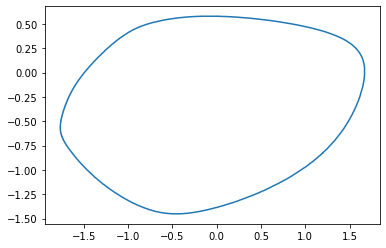

In [15]:
# plt.plot(oval[0], oval[1])
plt.plot(new_x, new_y)

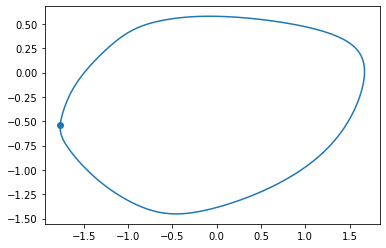

In [15]:
plt.plot(oval[0], oval[1])
plt.scatter(x[x_min_idx - 10], y[x_min_idx - 10])

In [ ]:
for i in range(x_max_idx, x_min_idx):
    x_ = x[i]
    diff = np.inf
    for y_ in y_limit:
        if y_ > y[i]:
            continue
            
        